# IMAGE COLORIZER

#### Sebastian Trattnig, Daniel Leustik

With the invention of the camera at the beginning of the 19th century, people were able to capture events forever.For a long time it was common practice to develop photos in black and white. With the reduction of the natural color spectrum a lot of information was lost. The colorful richness of that time could therefore not be captured.

With the help of Machine Learning, however, it is suddenly possible to bring color back into pictures that are actually black and white. Our motivation was therefore to be able to colorize existing photos with our own tool. There are already some existing tools, but they are mainly sold commercially. Other free services, on the other hand, often have restrictive usage rights, which makes unrestricted use impossible. Therefore the idea was born to develop a tool based on Machine Learning within the course.


Our initial plan was  as follows:
* We prepared a set of images, that would be used to train the algorithm
* Based on the results of our research about machine learning algorithms for image colorization, we would implement our own algorithm 
* Next step would be the training phase. The algorithm would be fed with the prepared training dataset of images on order to get a useful training model
* After the training phase selected images that have been transformed into black and white should be colorized properly again
* The resulting images of the colorization should then be compared to original color images pixel by pixel to determine the accuracy of our implementation 


In [3]:
import os
from PIL import Image
from IPython.display import display

## THEORY

LITERATUR: https://arxiv.org/abs/1712.03400

## OUR PLAN

Our input data are colored images with RGB values between 0-255. If we only working with these 3 color layers we would also have to predict three color layers. We came across a color spectrum which is called Lab and this is separated as follows:
* L --> Lightness, this is the layer with only grayscaled colors
* ab -->color channles

So the advantage of this is that we have one layer for representing grayscale and only two layers for the color spectrum. We can now use the original grayscale image in our final prediction and we also only have to predict two color channels instead of three.

## DATA ANALYSIS

Having the right data as input is crucial for getting the right output. At first, we tried to find enough images in our private repositories. As part of our research we found out that it would take several thousands of images for the training. Even if we were able to provide such a huge amount of images, another requirement is a high diversity of what is actually pictured. So we had to find a suitable library of images on the internet.

In the end we came across "Caltech 256 Image Dataset" (http://www.vision.caltech.edu/Image_Datasets/Caltech256/). On the first sight it fulfilled all our requirements. It offers 30k+ images in 257 categories. The categories consist of images in a range of 80 to 827 each. The median number is 100, mean 119. The categories themselves are very divers, the range starts at AK47 rifles and american flags and ends with yo-yos and zebras

Here are some samples from the dataset:

In [ ]:
for filename in os.listdir('images/01/'):
    display(Image.open('images/01/' + filename))
    

The aforementioned characteristics made the images basically suitable for using them as input for a general machine learning algorithm. Nevertheless there were some concerns. Greyscaled images were taken in a time, where some of the pictured elements were not yet existent. The question came up, how would including them in the data set influence our resulting model? Shouldn't we just include images of occurences that are part of old images? In the end we decided to keep the algorithm as general as possible. This also includes it to be able to colorize modern grey scale images.

### Data  Preparation


Regarding the sample images above it can be seen that they are not very consistent in terms of shape and size. To minimize future errors related to this issue when training the algorithm, the dataset had to be unified. With the decision to reshap the entire dataset to an image size of 256x256 pixels, we could optimize the training later on.
In this way we had the advantage that the size of the input shrank from 1.28GB to just 375MB. This resulted in a speed up when training the algorithm. Moreover, with images in this size, memory usage during the training was optimized additionally.

A major drawback of this process was a noticeable quality loss as well as the effect of images being clinched and stretched.
The quality loss was acceptable since it would lead to a faster training especially when regarding the size of the data set. For the distortion issue we assumed no influence on the capability of the model to colorize the images properly.

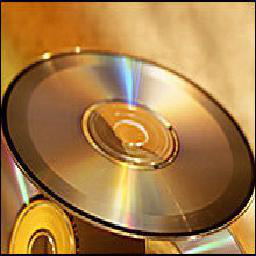

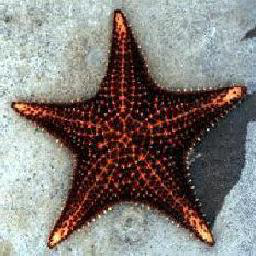

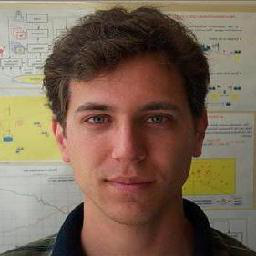

In [18]:
for filename in os.listdir('images/02/'):
    display(Image.open('images/02/' + filename))

## IMPLEMENTATION

### 1) Library import

As the first step in the implementation, all necessary imports have to be done.
The imports ranges from keras to skimage, numpy as well as matplot for drawing some fancy diagrams.

In [ ]:
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers import Activation, Dense, Dropout, Flatten, InputLayer
from keras.layers.normalization import BatchNormalization
from keras.callbacks import TensorBoard
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import ModelCheckpoint

from skimage.color import rgb2lab, lab2rgb, rgb2gray
from IPython.display import display
import matplotlib.pyplot as plt
from skimage.io import imsave
import tensorflow as tf
from PIL import Image
import numpy as np
import random
import shutil
import PIL
import os

### 2) Data import

The dataset has to be imported in order to make it available for the algorithm to be trained. In this step images are imported one after the another and appended to an array. Next, it is important to convert the array to an float array of images. We also have to consider RGB values which are from 0-255, but we need values between 0-1. Handling the data this way is required by the algorithm later on. 

In [ ]:
# collect data - filling an array with images using a loop
data = []
for filename in os.listdir('images/Images_version_1/Train/'):
    data.append(img_to_array(load_img('images/Images_version_1/Train/'+filename)))
    print(filename)

# convert image array to float array of images
data = np.array(data, dtype=float)

# set up train data - consider RGB value 255
Xtrain = data
Xtrain = 1.0/255*Xtrain

### 3) Model setup

Our predefined strategy was keras so we also came across sequential and functional models. In our case we took a sequential model which can be build up as a deep learning approach where the output from a previous layer serves as the input to the next layer.
We also came across the idea to use only a single layer neural network, but it turned out that such models can only be used to represent linearly separable function. This is very simple problems but in our case a multiple layer network is needed.

Then the quesiton "How many layers should we use?" have to be answered. Unfortunately there is no real rule of thumb to calculate this so we had to experiment with trail and error to find a suitable one. 

Functional layers allows you to connect a layer to any other number of layers. This means much more flexibility to build a complex network with multiple input or outputs, as well as the opportnity to share layers.

### ML Algorithms

There are four categories in which ML algorithms can be expressed.
Supervised, Unsupervised, Semi-Supervised and Reinforcement learning.

The idea behind our project was to use semi-supervised learning, because we get sample data with concrete goal variables on which will be trained as well as anonymous data on which will be tested.

The advantage is that we can train with only few photos and make a prediciton for the test images. This learning process is done by creating a Convolutional neural network. 

### CNN

Special type of neural network for working with two-dimensional image data. Basically we will use different layers with different filters which grows and shrinks and at the end we build up our intial size of image, the color channels as well as the grayscale channel.

In the context of a CNN a convolution is a linear operation that involves the multiplication of a set of weights. The ourput array from this operation is called a feature map. Once a feature map is created we can pass each value in the map through a nonlinearity, such as a ReLu.

In [ ]:
model = Sequential()
# define an input layer (only once) - input data have shape of 256x256
# be aware that convolutional takes a 3D input so we need to shape to 256x256 and 1 for 1 color space
# specifing input shape sets also the weight for our model

# 1st filter, 2st kernel space (3,3) <-- size of filter
# activation relu -- good for deep learning (tangente)
# padding - output from kernel will decrease - padding does that it will fill up cells with 0's
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(256, 256, 1)))
# strides -> nr or tuple - how much kernel should be moved (2 px)
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))
model.compile(optimizer='rmsprop', loss='mse' , metrics=["accuracy"])

model.summary()

### Hyperparameters

* Kernel Size - the size of the filter. ( In our case (3,3) )
* Kernel Type - values of the actual filter (e.g., edge detection, sharpen).
* Stride - the rate at which the kernel pass over the input image. ( move 2px )
* Padding - add layers of 0s to make sure the kernel pass over the edge of the image.
* Hidden layer - layers between input and output layers. ( Nr. 12 )
* Activation functions - allow the model to learn nonlinear prediction boundaries. ( RELU stands for Rectified Linear Unit is an activation function that converts all negative pixel values to 0 )
* Learning rate - regulates on the update of the weight at the end of each batch.
* Momentum - regulates the value to let the previous update influence the current weight update.
* The number of epochs - the iterations of the entire training dataset to the network during training.
* Batch size - the number of patterns shown to the network before the weights are updated.

The hyperparameter evaluations are being stored in training logs. You will see the loss-value as well as the value of acccuracy. 

### ImageDataGenerator & Model Training

After import of the dataset and setting up the model, the ImageDataGenerator prepares the input in a way the training function can process it. In general it just takes the input and slices it into batches of given sizes. It offers a lot of settings, e.g. for how the batches are generated or how the images have to be pre-processed. The model generator takes the batches and loops through them for a certain number of rounds (steps per epoch) before writing the new weighted model to the file.

In [ ]:
# Image datagenerator, adjust setting for img
datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True)

# Generate training data
batch_size = 29 

def image_a_b_gen(batch_size):
    for batch in datagen.flow(images_train, batch_size=batch_size):
        lab_batch = rgb2lab(batch)
        # extract b/w layer for x_batch, two color layers for y_batch
        X_batch = lab_batch[:,:,:,0]
        Y_batch = lab_batch[:,:,:,1:] / 128
        yield (X_batch.reshape(X_batch.shape+(1,)), Y_batch)


trainedmodel = model.fit_generator(image_a_b_gen(batch_size), epochs=50, steps_per_epoch=33)

### Evaluation/Testing
The best solution for getting fast overview over the results returned by a newly generated model we have a function that takes some images as input and colorizes them. A convenient solution is to take a few of the input images that are colorized. Those are being greyscaled before being colorized again. In the end the output of the colorization step - in this case the images - are written to a separate folder where they can be viewed.

In [ ]:
# colorizer section 
# init array and add img to color
images_to_color = []
for filename in os.listdir('Images_new/Test/'):
    images_to_color.append(img_to_array(load_img('Images_new/Test/'+filename)))

# covert color space, reshape img
images_to_color = np.array(images_to_color, dtype=float)
images_to_color = rgb2lab(1.0/255*images_to_color)[:,:,:,0]
images_to_color = images_to_color.reshape(images_to_color.shape+(1,))

# Test model with predict function
output = model.predict(images_to_color)

# covert color value back from [-1,1] to [-128,128] which is Lab color spectrum
output = output * 128

# Output colorizations
for i in range(len(output)):
    
    # make empty 256x256 with 3 layera
    cur = np.zeros((256, 256, 3))
    # copy grayscale layer to new obj
    cur[:,:,0] = images_to_color[i][:,:,0]
    # copy color layer to new obj
    cur[:,:,1:] = output[i]
    # save img in directory
    imsave("Images_new/Result/img_"+str(i)+".png", lab2rgb(cur))
    #imsave("Images_new/Result/img_"+str(i)+".png", img_as_ubyte(cur))

## EVALUATION
The first question was: "how big should our model and how many trainable parameters are needed?". At the beginning we builded different models with only 50k, 500k and this one with almost 4 billion parameters. After some few training sessions, it turned out that the model with the highest Nr. of parameters is actually working much better than the others, although it was a bit slow.

We used different layers and functions like UpSampling2D layer or the stride function, as well as different activation functions. 
* UpSampling is required to blow up (double) the size of the underlying layers vector. 
* Stride means to move kernel e.g. along the x axis by 2.
* Activation: We used ReLu because it is perfectly suitable as well as at the end we need to use a Tanh function because otherwise we would only get positive numbers a no negative numbers.

After implementing the presented algorithm, we could start to make our first tests. As execution environment we used our own PCs that we though of would be powerful enough to cope with the training of the entire dataset.
The specs of our machines are as follows:
##### Daniel:
* CPU:	Intel(R) Core(TM) i7-7700HQ CPU @ 2.80GHz, 2808 MHz, 4 cores, 8 logical processors
* RAM:	16,0 GB
* GPU:	NVIDIA Quadro M1200

##### Sebastian
* CPU:	Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, 1498 MHz, 4 cores, 8 logical processors
* RAM:	16,0 GB
* GPU:	---


Soon it was clear that the specs were not enough. When running the first test an error was raised and the message indicated an memory error:

In [ ]:
---------------------------------------------------------------------------
MemoryError                               Traceback (most recent call last)
<ipython-input-3-49ce63986d22> in <module>
      4 for filename in os.listdir('./Images_all/'):
      5     images.append(img_to_array(load_img('./Images_all/'+filename)))
----> 6 images = np.array(images, dtype=float)
      7 
      8 # Set up train and test data

MemoryError: 


The implementation of the algorithm was fine at first sight, also after a deeper comparison to our sources we could not find any error. The setup was just not able to handle the entire dataset at once. For going on with the training we decided on taking just a fraction of the dataset that was still a cross-section of the 257 categories. The new training dataset consisted of 1914 images eventually. When re-running the algorithm the respective patch was passed with ease. 

### Setting the hyperparameters
During the training phase there were three important parameters that would influence the resulting model.
* "Batch size" is the parameter representing the number of elements - in our case images - that are used to train the model during every step
* The "number of steps" decides how often new batches are used to train the model during every epoch before the results are written to the model file
* "Epochs" is the hyperparameter of gradient descent that says how often the dataset is passed by the algorithm.

It has to be mentioned that in an ideal case the equation B * N = E is fulfilled where B = batch size, N = number of steps and E = number of elements in the dataset. This gives a potential guarantee that every element is used once in a batch and there a no incomplete batches. 

To optimize the training phase i.e. speed-up the execution, the mentioned parameters should be chosen wisely. The number of epochs is basically independent of the two others. It influences the resulting model in the way that a high number means more passes and a more accurate model in the end. For the first tests we started with low values and increased this number steadily to rather high numbers (50-5000 epochs) beyond all over tests. To get some decent results 4-digit numbers where needed at least.

The two other values are then responsible for the execution time. Depending on the batch size, every step needs a certain time. Preferably the batch size should be set as high as possible, just below a value exceeding the available memory. Regarding the equation mentioned before the number of steps should be set to a value so every element of the dataset is used at least once. A higher number of usages of every element in a single epoch is a waste of time since it has already influenced the model in its way.

### Training

##### Complete reduced dataset
In our first tests we were using the 1914 elements dataset. The trainings were executed on our own machines. With setting up the GPU for training the speed could be increased remarkably.

The parameters for the test first test were:
* batch size: 29
* steps per epoch: 33
* number of epochs: 50

The execution time for this run was 43 mins. The loss was at around 0.013 and the accuracy fluctuated at 60%.

The results of this run were a beginning. We can see some slight changes from the greyscale version. Although the training time and number of epochs had to be further increased to get better results. 

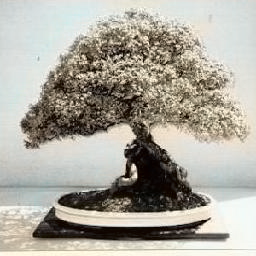

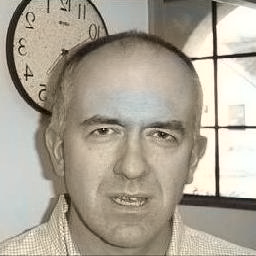

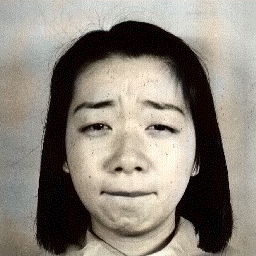

In [9]:
for filename in os.listdir('images/05/'):
    display(Image.open('images/05/' + filename))

When increasing the number of epochs to 500 one can see that the features are way more distinct:

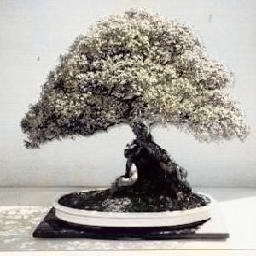

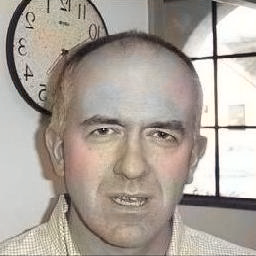

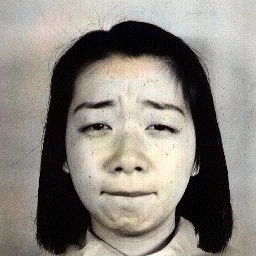

In [12]:
for filename in os.listdir('images/08/'):
    display(Image.open('images/08/' + filename))

Even if we were able to set up the GPUs on our machines to train the model, our resources still seemed to be limited. To get decent results we had to set the number of epochs very high (1000-2500) at least and since the batch size could not be increased further, the only parameter we could influence was the number of steps. During training we encountered the situation that just passing through the half of the dataset we couldn't perceive a loss of quality in the test images. This way we could reduced the training time by the factor of 2.


#### FloydHub
The training time still remained enormous. Some research led us to a website called Floydhub offering computational resources for machine learning tasks. We registered to test out the service with some free contingent of two hours on a GPU as well as 20 hrs on a CPU. The specs are listed here:

##### CPU:
* Intel Xeon® 
* 2 Cores
* 8 GB RAM
* 100 GB SSD


##### GPU:
* Tesla K80
* 12 GB Memory
* 61 GB RAM
* 100 GB SSD

Soon we realized this could help us with our issues regarding batch size and training time. The free quoata was spent in no time so we had to purchase more computation time. Due to the fact that 10 hrs of GPU time are around 10€ we had to decide carefully on what and how we wanted to train the model. Of interest was the runtime in the end so we decided on the following parameters for the 1914 element dataset:
* batch size: 87
* steps per epoch: 11
* number of epochs: 500

Compared to our trys on our own machine, we were able to increase the batch size by the factor of 3. This way we could reduce the number of steps by a factor of 3 and the volume of training data per epoch remained the same. The time needed for training was 3hrs 40mins. 

The colorized results after the training session:

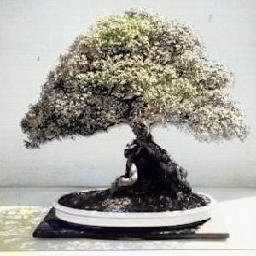

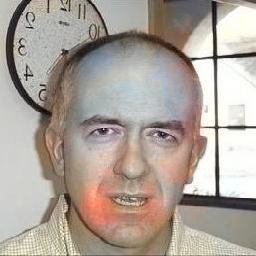

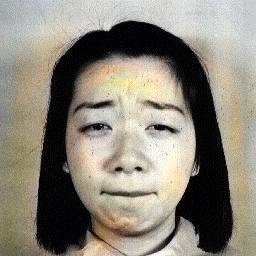

In [5]:
for filename in os.listdir('images/04/'):
    display(Image.open('images/04/' + filename))

Even though the number of epochs was still low one could already see that the model was already setting some colorful accents. It is also to be observed that in the third image - although it was greyscaled in the dataset - the girl had some colorize feature that were due to the dataset consisting of several other faces. 

A short calculation showed us, that increasing the number of epochs to 2500 would lead to a computation time of around 15 hrs. Such numbers of epochs would result in a more accurate output of the trained model. Computation with this setup was started in the evening. In this context, a big advantage of FloydHub is that you can always shut down your own PC since you are working remotely in a Jupyter notebook. Furthermore your own hardware is saved from running on 100% power over a long period.

A major drawback as we sadly had to encounter was the workspace management of FloydHub. If a workspace is idle it is shutdown automatically after half an hour by default. This is a mechanism to prevent the system from wasting expensive computation time.  Unfortunately the workspaces are not saved properly after the shutdown, so when you restart the workspace you are back at the very start and all progresses are lost.

In our case we didn't make it to enter the workspace before being shutdown and this long-running job was lost in the end. 17 hrs computation time spent for nothing. After this setback we backtracked from using FloydHub. The risks of executing long running jobs clearly outweighed the advantage of the speed-up we had when using the service.

#### Training with selected categories
In order to still get models producing presentable results we had to lower our own sights. The number of epochs should remain high due to the needed training effect. The other two parameters basically rely on the dataset. So a factor that can be influenced is the dataset itself. The dataset with 257 categories makes it very divers however training is very time and resource consuming. We came up with the idea of taking just a single category. In this way we wouldn't use a cross-section of each category but all elements of just one.

The category "faces" seemed to be the ideal one for training, it consisted of portraits of many different people. All in all the new dataset consisted of 435 elements looking like those examples:

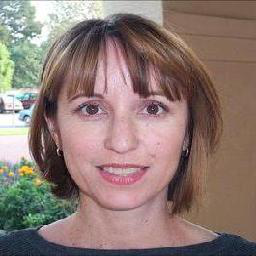

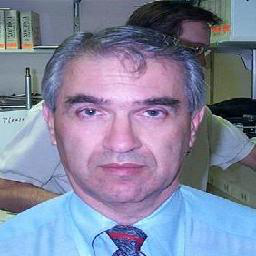

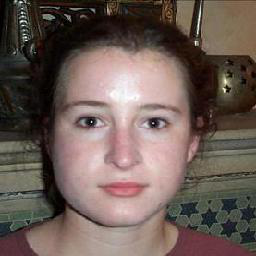

In [10]:
for filename in os.listdir('images/06/'):
    display(Image.open('images/06/' + filename))

The first tests with the dataset of just faces were promising from the beginning on. In our last training session we were using the following parameters:
* batch size: 100
* steps per epoch: 4
* number of epochs: 1000

After 6 hrs of computation the results were great, just a few flaws can be seen. This result was quite foreseeable, the loss during the training started at just .0075 and reached .003 after 100 epochs. In the end the loss was below .001. The results can be seen here:

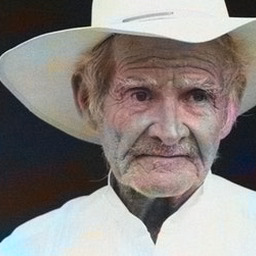

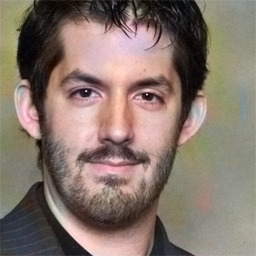

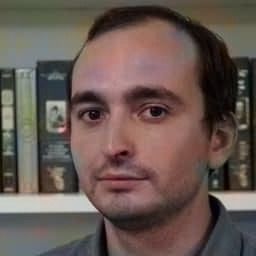

In [11]:
for filename in os.listdir('images/07/'):
    display(Image.open('images/07/' + filename))

### Objective Evaluation

As stated in our project proposal we wanted to evaluate the accuracy of our model by comapring the results to the input samples. Checking each pixel and calculating a ratio was a good measure at the beginning. Although from the very first beginning we saw that there was a discrepancy between our imagination and reality. We first thought, that in the end the significance of the results would be much lower having just a bunch of pixels not being accurate. As we have seen later there is a big difference to the input and it always dependent on the input dataset. So an image would never be colorized the way original one looks like. That is why we stood back from doing an evaluation based on this measure.

## CONCLUSION

Both of us have never been working on an AI/ML project before. Although this project gave us a good insight in what is really essential in this domain. Our results are not perfect yet and in the end the idea of a general image colorizer could no be implemented in the way we thought at the beginning of the course. 

### Computational resources
The first outputs of our trained model didn't seem to have any differences to the input of the test dataset, the "colorized" images were just a bit sepia-colored all over. The more we improved the setting of the hyperparameter the better the results got. A good setting in combination with a high number of epochs reduced the loss and increased the accuracy as we went along. In the same way the training time raised. Our own machines doing the calculations in the CPU were slow, execution on the GPU brought a speed-up but was still limited. Using the services of FloydHub gave us more possibilities although it is to be prefered when having a stable setup that has to be trained for a longer time. For doing some initial experiment it is too expensive.
In general a good hardware is worth gold, it can reduce the training time by a 2 digit factor compared to your stationary computer that is not even designed for such applications.


### Parameters
There's an enormous amount of hyperparameters that influence the resulting model in the one or the other way. It needs a lot of trial and error before getting into the scope of a good result. Adjusting the parameters more precisely then is some fine tuning for the model although in the case of image colorization it needs a lot of time to do so. Every adjustment should be then tested afterwards and the slight differences then have to be compared to the existing test series. All in all it is a very time consuming task to find the right setting for your training model. 

### Improvements for the future
During the test phase after the implementation we made a lot of experiments. We got a good feeling for what changes of hyperparameters make sense. To get some more accurate results we would be interested in starting a setting where the entire dataset is included (i.e. 30k+ images) and running for 5000-10000 epochs. If there were no hardware or financial limits it would still need a long time though. Nevertheless we are quite sure we would then get as good results as with that model just colorizing the faces.

## WORKLOAD DISTRIBUTION

As we did almost everything together we decided to also keep the part of describing our work together in a sheet.

At the beginning, we searched for the right project and we found a nice problem which can be solved through an AI. So the project image colorizer was born. Together we planned a meeting and worked out the proposal for the project. After some researching time we found the keras framework with its powerful features. The next step was to find the right dataset. So we both searched on different websites until we have had found a suitable one. After that, setting up our training data in a pixel array of float values between 0 and 1 was also done together.

The only thing, we have divided is building up the neural network and starting the training phase. The sequential model from keras was created by Sebastian. He created up three models with different numbers of hidden layers, different settings for activation function as well as different optimizer strategies. It turned out that, with more trainable parameters our output will get better quality but the computing time is much higher. This can be easily controlled with adjusting the number of layers as well as through using different sizes for the filters or neurons. To find an appropriate setting trial and error approach was used.
The process of training with the data was done by Daniel. This task was mainly about building up an ImageDataGenerator which is a special form of a generator which provides the feature of randomly adjusting images with different settings. If we do not use such an ImageDataGenerator we would always run over the same structure of pixels and our training will not be improved. The solution is to change the image dataset before each epoch and this can be done by using this defined generator. Before we start training we also have to adjust each image to the defined color space LAB. By creating a function we run through each batch and transform our RGB valued images to LAB valued images. For getting an overview of the learned aspects there was an object created in which all the history is stored. The actual training process will then be called with the function “fit_generator” which takes the previously defined function as argument.

After training we both worked on the rest which is drawing our diagrams from the history, saving and loading models as well as the last part in which the colorization is happening.

When the first version was finished we both trained separately and tried to optimize our approach and at the end we merged our aspects. The next weeks we tried to train as much as possible and also with different datasets but unfortunately we were very limited in memory and computing power as we both do not have access to some for such a project suitable GPU but apart from that our results are pretty good.
